<a href="https://colab.research.google.com/github/Antonsen2/wildfire-ai/blob/research/optimization/notebooks/optimization_CNN_image_classification_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.9 MB/s eta 0:00:00


# Set up


**In the setup section, we import a variety of libraries and modules that will be used in this optimization project. **

In [3]:
import keras_tuner
import os.path
import itertools
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow import keras
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

The !wget statement downloads a helper file called helper_functions.py, which contains functions that will be used in this optimization project.

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-02-10 09:59:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-10 09:59:42 (50.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Load dataset

*Mount the Google Drive to the Colab runtime and to set up variables to access the data stored in a directory in the Google Drive*

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATA_PATH = '/content/drive/MyDrive/full'
IMG_DIR = Path(DATA_PATH)

In [7]:
walk_through_dir(DATA_PATH)

There are 3 directories and 0 images in '/content/drive/MyDrive/full'.
There are 0 directories and 2071 images in '/content/drive/MyDrive/full/fire'.
There are 0 directories and 2150 images in '/content/drive/MyDrive/full/satellite'.
There are 0 directories and 500 images in '/content/drive/MyDrive/full/nonfire'.


## Prepare Dataset

**This section of code is preparing a dataset for a machine learning model. It starts by defining a function split_df that takes a DataFrame, a list of columns, and several keyword arguments, and returns a new DataFrame. **

In [8]:
def split_df(df: pd.DataFrame, cols: list, **kwargs) -> pd.DataFrame:
    df1 = pd.DataFrame()

    for k, v in kwargs.items():
        df2 = df.loc[df['Label'] == k][cols].sample(n=v)
        df1 = pd.concat([df1, df2])

    df1.index = range(len(df1))
    return df1

**Creates a list of file paths for all the images in the directory specified by the constant IMG_DIR and a corresponding list of labels based on the subdirectory name of each image. **

In [9]:
filepaths = list(IMG_DIR.glob(r'**/*.JPG')) + list(IMG_DIR.glob(r'**/*.jpg')) + list(IMG_DIR.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/content/drive/MyDrive/full/fire/fire-837.jpg,fire
1,/content/drive/MyDrive/full/fire/fire-1095.jpg,fire
2,/content/drive/MyDrive/full/fire/fire-759.jpg,fire
3,/content/drive/MyDrive/full/fire/fire-1047.jpg,fire
4,/content/drive/MyDrive/full/fire/fire-821.jpg,fire
...,...,...
4716,/content/drive/MyDrive/full/nonfire/forest-396...,nonfire
4717,/content/drive/MyDrive/full/nonfire/forest-401...,nonfire
4718,/content/drive/MyDrive/full/nonfire/forest-381...,nonfire
4719,/content/drive/MyDrive/full/nonfire/forest-458...,nonfire


In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
df_full = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=2071,
    nonfire=500
)

In [12]:
train_df, test_df = train_test_split(
    df_full, test_size=0.2, shuffle=True, random_state=42
)

In [13]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
RANDOM_SEED = 42

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1645 validated image filenames belonging to 2 classes.
Found 411 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


# Frist training

*Sets up two callbacks for the training process of a machine learning model: a ModelCheckpoint and an EarlyStopping callback: The ModelCheckpoint callback is used to save the best weights of the model during training. The EarlyStopping callback is used to stop the training process when the validation loss plateaus*

In [15]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

*Creates a MobileNetV2 object using the MobileNetV2 class from the TensorFlow applications module. This is a pre-trained deep learning model that has been trained on the ImageNet dataset.*

In [16]:
    pretrained_model = MobileNetV2(
      input_shape=IMG_SIZE+ (3,),
      include_top=False,
      weights='imagenet',
      pooling='avg')

9406464/9406464 [==============================] - 0s 0us/step


*Train model function for a binary image classification task. The function takes in two arguments, a pretrained model of MobileNetV2 and the training and validation images.*

In [17]:
def train_model(pretrained_model: MobileNetV2, train_images, val_images) -> tuple:
    # A sequential model that performs resizing and rescaling operations on the input image
    resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(*IMG_SIZE),
        layers.experimental.preprocessing.Rescaling(1./255),
    ])

    # Instantiate a MobileNetV2 model with pretrained weights from ImageNet dataset
    pretrained_model = MobileNetV2(
        input_shape=IMG_SIZE + (3,), # input shape with 3 color channels (RGB)
        include_top=False, # exclude the fully connected layer at the top
        weights='imagenet', # use the pretrained weights
        pooling='avg') # use average pooling as the global pooling operation
    
    # Get the inputs of the pretrained model
    inputs = pretrained_model.input
    # Apply the resize_and_rescale operations to the inputs
    X = resize_and_rescale(inputs)

    # Add a fully connected layer with 256 units, using ReLU activation
    X = Dense(256, activation='relu')(pretrained_model.output)
    # Apply dropout to reduce overfitting
    X = Dropout(0.2)(X)
    # Add another fully connected layer with 256 units, using ReLU activation
    X = Dense(256, activation='relu')(X)
    # Apply dropout to reduce overfitting
    X = Dropout(0.2)(X)

    # Add a final fully connected layer with 2 units, using softmax activation
    outputs = Dense(2, activation='softmax')(X)

    # Create a model with the input tensors as inputs and the output tensors as outputs
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(
        optimizer=Adam(0.0001), # Use Adam optimizer with a learning rate of 0.0001
        loss='categorical_crossentropy', # Use categorical crossentropy as the loss function
        metrics=['accuracy'] # Use accuracy as the evaluation metric
    )

    # Train the model, using the specified train_images and val_images for training and validation respectively
    history = model.fit(
        train_images, # training images
        steps_per_epoch=len(train_images), # number of steps per epoch
        validation_data=val_images, # validation images
        validation_steps=len(val_images), # number of validation steps
        epochs=100, # number of training epochs
        callbacks=[
            early_stopping, # use early stopping to stop the training if the validation loss stops improving
            create_tensorboard_callback(
                'training_logs', # directory to store the TensorBoard logs
                'fire_classification' # name of the run
            ),
            checkpoint_callback, # save the best model weights to the specified checkpoint path
        ]
    )
       # Return the trained model and its training history
    return model, history

In [18]:
# Train the model using the train_model function and get the model and its training history
model, history = train_model(pretrained_model, train_images, val_images)


Saving TensorBoard log files to: training_logs/fire_classification/20230210-100032
Epoch 1/100
52/52 [==============================] - 1303s 25s/step - loss: 0.1163 - accuracy: 0.9495 - val_loss: 0.1700 - val_accuracy: 0.9416
Epoch 2/100
52/52 [==============================] - 13s 241ms/step - loss: 0.0084 - accuracy: 0.9988 - val_loss: 0.1625 - val_accuracy: 0.9440
Epoch 3/100
52/52 [==============================] - 13s 251ms/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.1497 - val_accuracy: 0.9562
Epoch 4/100
52/52 [==============================] - 13s 246ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0922 - val_accuracy: 0.9684
Epoch 5/100
52/52 [==============================] - 13s 246ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9781
Epoch 6/100
52/52 [==============================] - 13s 244ms/step - loss: 7.9845e-04 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9732
Epoch 7/100
52/52 [==============================

## Check overfitting

In [19]:
def plot_accuracy(history, miny=None):
  # Get the accuracy values from the training and validation datasets
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  
  # Create a range of epochs
  epochs = range(len(acc))
  
  # Plot the accuracy values for both the training and validation datasets
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  
  # If the miny argument is specified, set the lower limit of the y-axis to the specified value
  if miny:
    plt.ylim(miny, 1.0)
  
  # Set the title of the plot
  plt.title('accuracy') 
  
  # Create a new figure
  plt.figure()

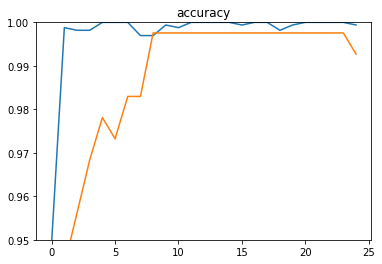

<Figure size 432x288 with 0 Axes>

In [20]:
plot_accuracy(history, miny=0.95)

# Model Optimization

*This function build_model takes in an argument hp which is an object of the Hyperparameters class from the hyperopt library. The purpose of this function is to build a machine learning model for binary image classification. The model is built using the MobileNetV2 architecture and has two additional dense layers on top of it. The hyperparameters of the model are defined using the hp object and can be optimized using hyperopt's algorithms.*

In [21]:
def build_model(hp):
    # Create a sequence of image preprocessing layers
    resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(*IMG_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255),])

    # Load the pre-trained MobileNetV2 model, using the ImageNet weights, and set the pooling layer to average pooling.
    pretrained_model = MobileNetV2(
      input_shape=IMG_SIZE + (3,),
      include_top=False,
      weights='imagenet',
      pooling='avg')

    # Freeze the weights of the pre-trained model so they won't be updated during training.
    pretrained_model.trainable = False

    # Create the input tensor for the model
    inputs = pretrained_model.input
    X = resize_and_rescale(inputs)

    # Add the first dense layer with the number of units and activation function determined by the hyperparameters.
    X = Dense(
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation=hp.Choice("activation1", ["relu", "tanh", "sigmoid"], ordered=False))(pretrained_model.output)
    # Add a dropout layer for regularization.
    X = Dropout(0.2)(X)

    # Add the second dense layer with the number of units and activation function determined by the hyperparameters.
    X = Dense(
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation=hp.Choice("activation2", ["relu", "tanh", "sigmoid"], ordered=False))(X)
    # Add another dropout layer for regularization.
    X = Dropout(0.2)(X)

    # Add the final dense layer with the activation function determined by the hyperparameters.
    outputs = Dense(2, activation=hp.Choice("activation3", ["softmax", "sigmoid", "linear"], ordered=False))(X)

    # Create the model with the specified inputs and outputs.
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with an optimizer, loss function, and metric(s) determined by the hyperparameters.
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate',
                                 [1e-2, 1e-4], ordered=False)),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model


## Start the search

*This code initializes a RandomSearch tuner object from the keras_tuner library. The tuner will perform hyperparameter optimization on the build_model function by performing random search over the hyperparameters defined in the build_model function, with the goal of maximizing the validation accuracy.*

In [22]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="keras_tuning",
    project_name="wildfire",
)

In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
activation3 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'linear'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': False}


In [24]:
tuner.search(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=3
    )

Trial 3 Complete [00h 01m 03s]
val_accuracy: 0.10218978207558393

Best val_accuracy So Far: 0.9951338171958923
Total elapsed time: 00h 02m 58s


## Query the results

In [25]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [26]:
# The tuner.results_summary() method shows a summary of the hyperparameter tuning results, including the performance metrics of each trial. 
tuner.results_summary()

Results summary
Results in keras_tuning/wildfire
Showing 10 best trials
Trial summary
Hyperparameters:
units: 160
activation1: tanh
activation2: tanh
activation3: sigmoid
learning_rate: 0.0001
Score: 0.9951338171958923
Trial summary
Hyperparameters:
units: 320
activation1: sigmoid
activation2: relu
activation3: sigmoid
learning_rate: 0.0001
Score: 0.9951338171958923
Trial summary
Hyperparameters:
units: 480
activation1: tanh
activation2: sigmoid
activation3: linear
learning_rate: 0.01
Score: 0.10218978207558393


In [27]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print(best_hps.get("activation1"))
print(best_hps.get("activation2"))
print(best_hps.get("activation3"))
print(best_hps.get("units"))
print(best_hps.get("learning_rate"))

tanh
tanh
sigmoid
160
0.0001


The output shows the best hyperparameters that have been found as a result of the tuning process. The hyperparameters include:



*   "activation1": tanh
*   "activation2": tanh
*   "activation3": sigmoid
*   "units": 448
*   "learning_rate": 0.0001

These hyperparameters are considered the optimal configuration for the model, as they provided the best results for the validation set during the tuning process.